Todo:
Something is wrong with the scoring. There are a lot of NaNs, especially for late 2015 early 2016. I suspect that while building the list for populating the score column memory runs out.

In [29]:
import re
import spacy
from spacy_sentiws import spaCySentiWS
import bs4 as bs
import os, time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set
sns.set_context("paper")
nlp = spacy.load('de', disable=["ner", "textcat"])
sentiws = spaCySentiWS(sentiws_path=os.path.join(os.getcwd(), 'aux'))
nlp.add_pipe(sentiws)

In [8]:
input_path = os.path.join(os.getcwd(), "input")
articles = pd.read_csv(os.path.join(input_path, "articles.csv"), parse_dates=["date_published"])

In [9]:
articles.head()

,headline_intro,headline,date_published,content
0,Migrationspolitik in Portugal,"Das Land, das mehr Flüchtlinge aufnehmen will",2018-07-25 20:19:00,"<p>Als das Flüchtlingsrettungsschiff ""Lifeline..."
1,EU-Grenze zu Marokko,Hunderte Flüchtlinge stürmen spanische Exklave...,2018-07-26 13:45:00,<p>Immer wieder erklimmen Flüchtlinge den Gren...
2,Flüchtlingselend in Libyen,"""Europa schickt Menschen in die Hölle""",2018-07-26 15:30:00,<p>Die Türkei war nur der Anfang: Die EU-Staat...
3,CSU-Minister,Scheuer gibt den Hardliner in der Flüchtlingsp...,2018-07-21 09:43:00,"<p>In der Fußballnationalmannschaft, so sieht ..."
4,Inszenierung in München,Performance entlarvt Verstecke des Geheimdiensts,2018-07-21 11:45:00,"<p>Es könnte so harmlos wirken, doch als die a..."


In [10]:
def parse_text(text):
    """Cleans the columns in text_features. Returns a pandas series"""
    text = bs.BeautifulSoup(text, "html.parser").getText()
    return text

def clean_text(text, substitution_dict):
    for key, value in sub_dict.items():
        text = re.sub(key, value, text)
    return text

# Define dictionary with patterns to substitute for cleaning purposes
sub_dict = {
    "\n\n": "\n",
}

In [11]:
articles = articles[articles["date_published"] >= "2015-01-01"].dropna()
articles.loc[:, "content"] = articles.loc[:, "content"].apply(lambda x: parse_text(x)).apply(lambda x: clean_text(x, sub_dict))

In [12]:
# TODO: It is probably good to give each article an ID in my collection so that I don't have to save the whole doc with the score.
def score_articles(doc, targets):
    sentiments = [token._.sentiws for token in doc if (token._.sentiws) and (token.lower_ not in targets)]
    if len(sentiments) > 0:
        score = sum(sentiments) / len(sentiments)
        return score
    return 0. 

In [13]:
targets = ["flüchtlinge", "flüchtling", "flüchtlingen", "flüchtlingsunterkunft", "flüchtlingsroute", "flüchtlingsroute", "flüchtlingswelle", 
           "geflüchtete", "geflüchteter", "geflüchtete", 
           "asylbewerber", "asylsuchender", "asylant", 
           "migrant", "migranten", "migrantin"]

In [14]:
docs_generator = nlp.pipe(articles.loc[:, "content"], batch_size=1000, n_threads=2)
articles = articles.assign(score = pd.Series((score_articles(doc, targets) for doc in docs_generator)))

In [43]:
articles["year-month"] = articles.loc[:, "date_published"].map(lambda x: str(x.year) + "-" + str(x.month))
articles["year-month"] = pd.to_datetime(articles["year-month"])
articles.set_index("year-month", inplace=True)

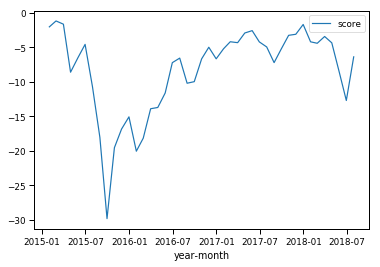

In [46]:
sns.lineplot(data=articles.resample("M").sum());

In [76]:
# Tem most "positive" articles
articles.sort_values("score", ascending=False).iloc[0:10, 1]

year-month
2017-01-01    Staatsanwaltschaft wirft Angeklagten religiöse...
2015-11-01    Bundesregierung plant Ausweitung der Eilverfahren
2016-04-01                             Jesus war nicht tolerant
2016-01-01         Flüchtlinge warten bei Eiseskälte vor Lageso
2017-10-01    Ein Ex-Mitarbeiter des Bundesamts für Flüchtli...
2016-12-01    Tausende Flüchtlinge gelten ab Neujahr als vol...
2015-09-01                    Brand an geplanter Asylunterkunft
2015-09-01    Linke nennen USA Hauptverursacher der Flüchtli...
2015-12-01    Arbeitsvermittler sollen 3600 Mitarbeiter zusä...
2016-07-01        Die sollen erst mal anständig Deutsch lernen!
Name: headline, dtype: object

### EDA

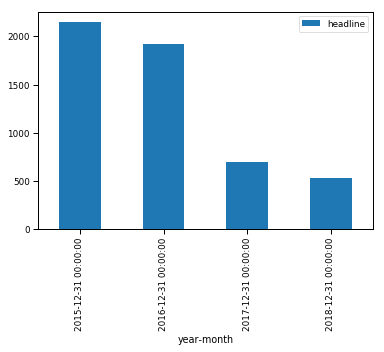

In [98]:
articles.loc[:, ["headline"]].resample("Y").count().plot.bar();

In [62]:
def score_sentences(doc, targets):
    """Score sentences that contain any of the target patterns. Returns a list of tuples"""
    compiled_targets = [re.compile(target) for target in targets]
    results = []
    for sentence in doc.sents:
        if any(target.search(sentence.lower_) for target in compiled_targets):
            # I exclude "Flüchtlinge" and synonyms because they are scored as negative sentiment in the model
            sentiments = [token._.sentiws for token in sentence if token._.sentiws and token.lower_ not in targets]
            if len(sentiments) > 0:
                score = sum(sentiments) / len(sentiments)
                results.extend(sentence, score)
    return results

# Citations
- R. Remus, U. Quasthoff & G. Heyer: SentiWS - a Publicly Available German-language Resource for Sentiment Analysis.
In: Proceedings of the 7th International Language Ressources and Evaluation (LREC'10), pp. 1168-1171, 2010